<a href="https://colab.research.google.com/github/emredeveloper/Advanced-Segmantasyon-Projesi/blob/master/semantic_segmantation_save_on_sql.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import sqlite3
from io import BytesIO
from PIL import Image
import requests
import torch
from torchvision import models, transforms

# SQLite veritabanı bağlantısı
conn = sqlite3.connect('output_database.db')
cursor = conn.cursor()

In [51]:
import sqlite3
from io import BytesIO
from PIL import Image
import requests
import torch
from torchvision import models, transforms
import matplotlib.pyplot as plt

# SQLite veritabanı bağlantısı
conn = sqlite3.connect('output_database.db')
cursor = conn.cursor()

# Tabloyu oluşturma (bir kere yapılması yeterlidir)
cursor.execute('''
    CREATE TABLE IF NOT EXISTS labeled_images (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        original_image BLOB,
        labeled_image BLOB,
        label TEXT
    )
''')
conn.commit()

In [52]:
# DeepLab modelini yükleme
deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()

# Görüntüyü indirme ve işleme
image_url = "https://www.kopekler.com/assets/media/b1ddd-kapak1.jpg"
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(img)
input_batch = input_tensor.unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
# Girişi modelden geçirme
with torch.no_grad():
    output = deeplab(input_batch)['out'][0]

# Çıkışı renklendirme
output_predictions = output.argmax(0)
color_map = torch.tensor([
    [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
    [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
    [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128], [64, 128, 128],
    [192, 128, 128], [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
    [0, 64, 128]
])

segmented_image = color_map[output_predictions]

In [54]:
import numpy as np

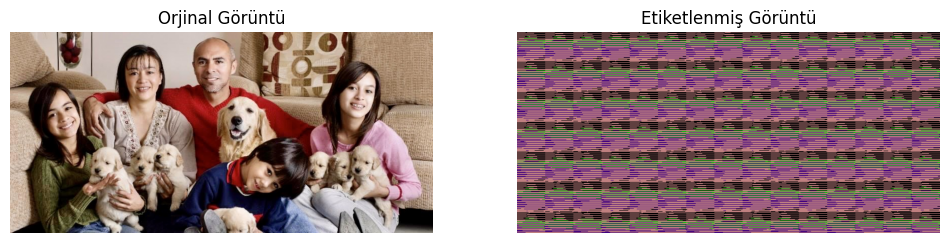

In [55]:
import numpy as np

# Etiketleri görüntüye ekleme
labeled_image = np.zeros_like(img)

for label, color in enumerate(color_map):
    mask = (output_predictions.numpy() == label)  # output_predictions'ı numpy array'e çevir
    label_color = color.numpy().astype('uint8')

    mask_3d = np.stack([mask] * 3, axis=-1)  # Maskeyi 3 kanallı yapma
    colored_mask = np.multiply(mask_3d, label_color)  # Maskenin rengini etiket rengiyle çarpma

    # Resim ve maskelerin şekillerini eşitleme
    if colored_mask.shape != labeled_image.shape:
        colored_mask = np.resize(colored_mask, labeled_image.shape)

    labeled_image += colored_mask  # Görüntüyü güncelleme

# Görüntüyü ve etiketleri görselleştirme
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
axs[0].set_title("Orjinal Görüntü")
axs[0].axis('off')
axs[1].imshow(labeled_image)
axs[1].set_title("Etiketlenmiş Görüntü")
axs[1].axis('off')
plt.show()